# Modelo MesoNet

MesoNet: a Compact Facial Video Forgery Detection Network

Artigo: https://arxiv.org/pdf/1809.00888.pdf

Github: https://github.com/DariusAf/MesoNet

Vídeo sobre: https://youtu.be/kYeLBZMTLjk

Solução: Foi utilizado as redes convolucionais meso-4 e mesoinception-4. Nas saídas das convoluções, vídeos reais apresentaram ativação (valores maiores) na área do rosto, em especial nos olhos, enquanto que os de deepfake. O que vai de encontro a percepção visual de que os vídeos deepfake costumam apresentar certo embaçamento.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import mlflow
from mlflow.models.signature import infer_signature
mlflow.set_experiment('Projeto Aplicado XPE - Detector de Deep Fake')

<Experiment: artifact_location='file:///Volumes/1TB/Proj-Aplicado-XPE-MBA-Machine-Learning/notebooks/mlruns/706091484860546630', creation_time=1688931623478, experiment_id='706091484860546630', last_update_time=1688931623478, lifecycle_stage='active', name='Projeto Aplicado XPE - Detector de Deep Fake', tags={}>

In [2]:
# Tamanho a imagem e canais
image_dimensions = {'height':256, 'width':256, 'channels':3}

# Classe do classificador
class Classifier:
    def __init__():
        self.model = 0 
    def predict(self, x):
        return self.model.predict(x)  
    def fit(self, x, y):
        return self.model.train_on_batch(x, y)
    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)
    def load(self, path):
        self.model.load_weights(path)

# Rede Mesonet usando o Classificador
class Meso4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer,
                           loss = 'mean_squared_error',
                           metrics = ['accuracy'])
    
    def init_model(self): 
        x = Input(shape = (image_dimensions['height'],
                           image_dimensions['width'],
                           image_dimensions['channels']))
        
        x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return Model(inputs = x, outputs = y)
    
# Utilização de pesos já treinados
meso = Meso4()
meso.load('../src/models/Meso4_DF.h5')

/Users/diegoabreu/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Dataset CelebDF

In [4]:
# dataframe
dataset = 'celebdf'
dataframe_faces= pd.read_csv('../data/processed/dataset_'+dataset+'/metadados_faces.csv', sep=';', dtype=str)
dataframe_faces_teste = dataframe_faces[dataframe_faces['particao']=='teste'].reset_index(drop=True)

In [5]:
# Preparação da imagem

# Rescaling pixel values (between 1 and 255) to a range between 0 and 1
dataGenerator = ImageDataGenerator(rescale=1./255)

# Instantiating generator to feed images through the network
generator = dataGenerator.flow_from_dataframe(
    dataframe_faces_teste,
    x_col='face',
    y_col='label',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary')

Found 17601 validated image filenames belonging to 2 classes.


1/1 [==============================] - 0s 141ms/step
Predicted likelihood: 0.0346
Actual label: 0
1/1 [==============================] - 0s 21ms/step

Correct prediction: True


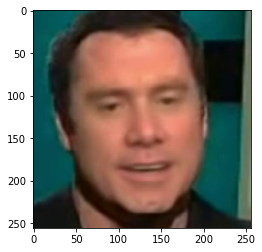

In [5]:
# teste
# Rendering image X with label y for MesoNet
X, y = generator.next()

# Evaluating prediction
print(f"Predicted likelihood: {meso.predict(X)[0][0]:.4f}")
print(f"Actual label: {int(y[0])}")
print(f"\nCorrect prediction: {round(meso.predict(X)[0][0])==y[0]}")

# Showing image
plt.imshow(np.squeeze(X));

In [8]:
test_x =[]
test_y = []
test_pred = []
test_pred_label = []
for i in range(len(generator.labels)):  
#for i in range(1000):  
    # Loading next picture, generating prediction
    try:
        X, y = generator.next()
        pred = meso.predict(X)[0][0]
        test_x.append(X)
        test_y.append(round(y[0]))
        test_pred.append(pred)
        test_pred_label.append(round(pred))
    except:
        pass

resultados = pd.DataFrame(data = {"test_x" : test_x, "test_y" : test_y, "test_pred": test_pred, "test_pred_label": test_pred_label})

In [6]:
previsoes = resultados['test_pred_label']
y = resultados['test_y']
prob_previsao = resultados['test_pred']
processamento = 'MesoNet4_'+dataset
with mlflow.start_run(run_name=processamento):
    #lr = LinearRegression()
    #lr.fit(X_train, y_train)
    #mlflow.sklearn.log_model(meso,'MesoNet4')
    #signature = infer_signature(X[0][0], meso.predict(X)[0][0])
    #mlflow.tensorflow.log_model(meso, "MesoNet4")
    #lr_predicted = lr.predict(X_test)
    
    report = classification_report(y, previsoes, output_dict=True)
    acuracia = accuracy_score(y, previsoes)
    mlflow.log_metric('accuracy', acuracia)
    mlflow.log_metric('precision_0', report['0']['precision'])
    mlflow.log_metric('recall_0', report['0']['recall'])
    mlflow.log_metric('f1-score_0', report['0']['f1-score'])
    mlflow.log_metric('precision_1', report['1']['precision'])
    mlflow.log_metric('recall_1', report['1']['recall'])
    mlflow.log_metric('f1-score_1', report['1']['f1-score'])
    auc = roc_auc_score(y, prob_previsao)
    mlflow.log_metric('roc_auc',auc)
    matriz_confusao = confusion_matrix(y,previsoes)
    mlflow.log_metric('0_True_matrix' ,matriz_confusao[0][0])
    mlflow.log_metric('0_False_matrix', matriz_confusao[0][1])
    mlflow.log_metric('1_False_matrix',matriz_confusao[1][0])
    mlflow.log_metric('1_True_matrix',matriz_confusao[1][1])

### Dataset faceforensics

In [7]:
# dataframe
dataset = 'faceforensics'
dataframe_faces= pd.read_csv('../data/processed/dataset_'+dataset+'/metadados_faces.csv', sep=';', dtype=str)
dataframe_faces_teste = dataframe_faces[dataframe_faces['particao']=='teste'].reset_index(drop=True)

In [8]:
# Preparação da imagem

# Rescaling pixel values (between 1 and 255) to a range between 0 and 1
dataGenerator = ImageDataGenerator(rescale=1./255)

# Instantiating generator to feed images through the network
generator = dataGenerator.flow_from_dataframe(
    dataframe_faces_teste,
    x_col='face',
    y_col='label',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary')

Found 15005 validated image filenames belonging to 2 classes.


1/1 [==============================] - 0s 24ms/step
Predicted likelihood: 0.0179
Actual label: 0
1/1 [==============================] - 0s 39ms/step

Correct prediction: True


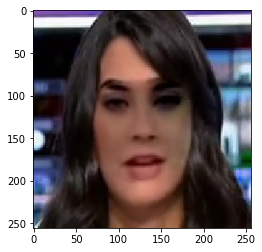

In [28]:
# teste
# Rendering image X with label y for MesoNet
X, y = generator.next()

# Evaluating prediction
print(f"Predicted likelihood: {meso.predict(X)[0][0]:.4f}")
print(f"Actual label: {int(y[0])}")
print(f"\nCorrect prediction: {round(meso.predict(X)[0][0])==y[0]}")

# Showing image
plt.imshow(np.squeeze(X));

In [ ]:
test_x =[]
test_y = []
test_pred = []
test_pred_label = []
for i in range(len(generator.labels)):  
#for i in range(1000):  
    # Loading next picture, generating prediction
    try:
        X, y = generator.next()
        pred = meso.predict(X)[0][0]
        test_x.append(X)
        test_y.append(round(y[0]))
        test_pred.append(pred)
        test_pred_label.append(round(pred))
    except:
        pass

resultados = pd.DataFrame(data = {"test_x" : test_x, "test_y" : test_y, "test_pred": test_pred, "test_pred_label": test_pred_label})

In [10]:
previsoes = resultados['test_pred_label']
y = resultados['test_y']
prob_previsao = resultados['test_pred']
processamento = 'MesoNet4_'+dataset
with mlflow.start_run(run_name=processamento):
    #lr = LinearRegression()
    #lr.fit(X_train, y_train)
    #mlflow.sklearn.log_model(meso,'MesoNet4')
    #signature = infer_signature(X[0][0], meso.predict(X)[0][0])
    #mlflow.tensorflow.log_model(meso, "MesoNet4")
    #lr_predicted = lr.predict(X_test)
    
    report = classification_report(y, previsoes, output_dict=True)
    acuracia = accuracy_score(y, previsoes)
    mlflow.log_metric('accuracy', acuracia)
    mlflow.log_metric('precision_0', report['0']['precision'])
    mlflow.log_metric('recall_0', report['0']['recall'])
    mlflow.log_metric('f1-score_0', report['0']['f1-score'])
    mlflow.log_metric('precision_1', report['1']['precision'])
    mlflow.log_metric('recall_1', report['1']['recall'])
    mlflow.log_metric('f1-score_1', report['1']['f1-score'])
    auc = roc_auc_score(y, prob_previsao)
    mlflow.log_metric('roc_auc',auc)
    matriz_confusao = confusion_matrix(y,previsoes)
    mlflow.log_metric('0_True_matrix' ,matriz_confusao[0][0])
    mlflow.log_metric('0_False_matrix', matriz_confusao[0][1])
    mlflow.log_metric('1_False_matrix',matriz_confusao[1][0])
    mlflow.log_metric('1_True_matrix',matriz_confusao[1][1])

### Dataset DFDC

In [11]:
# dataframe
dataset = 'dfdc'
dataframe_faces= pd.read_csv('../data/processed/dataset_'+dataset+'/metadados_faces.csv', sep=';', dtype=str)
dataframe_faces_teste = dataframe_faces[dataframe_faces['particao']=='teste'].reset_index(drop=True)

In [12]:
# Preparação da imagem

# Rescaling pixel values (between 1 and 255) to a range between 0 and 1
dataGenerator = ImageDataGenerator(rescale=1./255)

# Instantiating generator to feed images through the network
generator = dataGenerator.flow_from_dataframe(
    dataframe_faces_teste,
    x_col='face',
    y_col='label',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary')

Found 1220 validated image filenames belonging to 2 classes.


1/1 [==============================] - 0s 23ms/step
Predicted likelihood: 0.3490
Actual label: 0
1/1 [==============================] - 0s 23ms/step

Correct prediction: True


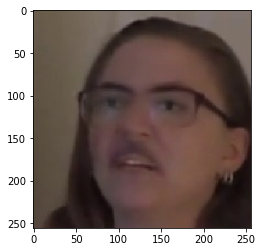

In [33]:
# teste
# Rendering image X with label y for MesoNet
X, y = generator.next()

# Evaluating prediction
print(f"Predicted likelihood: {meso.predict(X)[0][0]:.4f}")
print(f"Actual label: {int(y[0])}")
print(f"\nCorrect prediction: {round(meso.predict(X)[0][0])==y[0]}")

# Showing image
plt.imshow(np.squeeze(X));

In [ ]:
test_x =[]
test_y = []
test_pred = []
test_pred_label = []
for i in range(len(generator.labels)):  
#for i in range(1000):  
    # Loading next picture, generating prediction
    try:
        X, y = generator.next()
        pred = meso.predict(X)[0][0]
        test_x.append(X)
        test_y.append(round(y[0]))
        test_pred.append(pred)
        test_pred_label.append(round(pred))
    except:
        pass

resultados = pd.DataFrame(data = {"test_x" : test_x, "test_y" : test_y, "test_pred": test_pred, "test_pred_label": test_pred_label})

In [14]:
previsoes = resultados['test_pred_label']
y = resultados['test_y']
prob_previsao = resultados['test_pred']
processamento = 'MesoNet4_'+ dataset
with mlflow.start_run(run_name=processamento):
    #lr = LinearRegression()
    #lr.fit(X_train, y_train)
    #mlflow.sklearn.log_model(meso,'MesoNet4')
    #signature = infer_signature(X[0][0], meso.predict(X)[0][0])
    #mlflow.tensorflow.log_model(meso, "MesoNet4")
    #lr_predicted = lr.predict(X_test)
    
    report = classification_report(y, previsoes, output_dict=True)
    acuracia = accuracy_score(y, previsoes)
    mlflow.log_metric('accuracy', acuracia)
    mlflow.log_metric('precision_0', report['0']['precision'])
    mlflow.log_metric('recall_0', report['0']['recall'])
    mlflow.log_metric('f1-score_0', report['0']['f1-score'])
    mlflow.log_metric('precision_1', report['1']['precision'])
    mlflow.log_metric('recall_1', report['1']['recall'])
    mlflow.log_metric('f1-score_1', report['1']['f1-score'])
    auc = roc_auc_score(y, prob_previsao)
    mlflow.log_metric('roc_auc',auc)
    matriz_confusao = confusion_matrix(y,previsoes)
    mlflow.log_metric('0_True_matrix' ,matriz_confusao[0][0])
    mlflow.log_metric('0_False_matrix', matriz_confusao[0][1])
    mlflow.log_metric('1_False_matrix',matriz_confusao[1][0])
    mlflow.log_metric('1_True_matrix',matriz_confusao[1][1])

***

Treino com base mista

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import mlflow
from mlflow.models.signature import infer_signature
mlflow.set_experiment('Projeto Aplicado XPE - Detector de Deep Fake')

<Experiment: artifact_location='file:///Volumes/1TB/Proj-Aplicado-XPE-MBA-Machine-Learning/notebooks/mlruns/706091484860546630', creation_time=1688931623478, experiment_id='706091484860546630', last_update_time=1688931623478, lifecycle_stage='active', name='Projeto Aplicado XPE - Detector de Deep Fake', tags={}>

In [2]:
# Tamanho a imagem e canais
image_dimensions = {'height':256, 'width':256, 'channels':3}

# Classe do classificador
class Classifier:
    def __init__():
        self.model = 0 
    def predict(self, x):
        return self.model.predict(x)  
    def fit(self, x, y):
        return self.model.train_on_batch(x, y)
    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)
    def load(self, path):
        self.model.load_weights(path)

# Rede Mesonet usando o Classificador
class Meso4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer,
                           loss = 'mean_squared_error',
                           metrics = ['accuracy'])
    
    def init_model(self): 
        x = Input(shape = (image_dimensions['height'],
                           image_dimensions['width'],
                           image_dimensions['channels']))
        
        x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return Model(inputs = x, outputs = y)
    
# Utilização de pesos já treinados
# Utilização de pesos já treinados
meso = Meso4()
meso.load('../src/models/Meso4_DF.h5')

/Users/diegoabreu/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [3]:
# dataframe
dataframe_faces= pd.read_csv('../data/processed/dataset_misto/metadados_faces.csv', sep=';', dtype=str)
dataframe_faces_teste = dataframe_faces[dataframe_faces['particao']=='teste'].reset_index(drop=True)
dataframe_faces_treino = dataframe_faces[dataframe_faces['particao']=='treino'].reset_index(drop=True)


In [17]:
# Preparação da imagem

# Rescaling pixel values (between 1 and 255) to a range between 0 and 1
dataGenerator = ImageDataGenerator(rescale=1./255)

# Instantiating generator to feed images through the network
generator_treino = dataGenerator.flow_from_dataframe(
    dataframe_faces_treino,
    x_col='face',
    y_col='label',
    target_size=(256, 256),
    batch_size=10,
    class_mode='binary',
    shuffle=False)

# Instantiating generator to feed images through the network
generator_teste = dataGenerator.flow_from_dataframe(
    dataframe_faces_teste,
    x_col='face',
    y_col='label',
    target_size=(256, 256),
    batch_size=10,
    class_mode='binary',
    shuffle=False)


Found 26873 validated image filenames belonging to 2 classes.
Found 11426 validated image filenames belonging to 2 classes.


In [18]:
inp = Input((256,256,3))
conv1 = Conv2D(64, (5,5), padding='valid', activation= 'relu')(inp)
conv1 = MaxPooling2D(pool_size=(2,2))(conv1)
conv1 = BatchNormalization()(conv1)
conv2 = Conv2D(96, (4,4), padding='valid', activation= 'relu')(conv1)
conv2 = MaxPooling2D(pool_size=(2,2))(conv2)
conv2 = BatchNormalization()(conv2)
conv3 = Conv2D(128, (3,3), padding='valid', activation= 'relu')(conv2)
conv3 = MaxPooling2D(pool_size=(2,2))(conv3)
conv3 = BatchNormalization()(conv3)
conv4 = Conv2D(256, (3,3), padding='valid', activation= 'relu')(conv3)
conv4 = MaxPooling2D(pool_size=(2,2))(conv4)
conv4 = BatchNormalization()(conv4)
flat = Flatten()(conv4)
dense1 = Dense(512, activation= 'relu')(flat)
dense1 = Dropout(0.5)(dense1)
dense2 = Dense(64, activation= 'relu')(dense1)
dense2 = Dropout(0.1)(dense2)
out = Dense(1, activation = 'softmax')(dense2)
model_transf = Model(inp, out)
model_transf.compile(optimizer = Adam(lr = 0.0001) , loss = 'categorical_crossentropy', metrics=['accuracy'])

/Users/diegoabreu/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [20]:
STEP_SIZE_TRAIN=generator_treino.n//generator_treino.batch_size
STEP_SIZE_VALID=generator_teste.n//generator_teste.batch_size
history = model_transf.fit_generator(generator=generator_treino,steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=generator_teste,validation_steps=STEP_SIZE_VALID,
                                       epochs=1)

<ipython-input-20-055967f4ff00>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_transf.fit_generator(generator=generator_treino,steps_per_epoch=STEP_SIZE_TRAIN,


 716/2687 [======>.......................] - ETA: 29:04 - loss: 0.0000e+00 - accuracy: 0.4969

KeyboardInterrupt: 

In [ ]:
x = meso.output
x = Flatten()(x)
x = Dense(3078,activation='relu')(x) 
x = Dropout(0.5)(x)
x = Dense(256,activation='relu')(x) 
x = Dropout(0.2)(x)
out = Dense(1,activation='softmax')(x)
tf_model=Model(inputs=meso.input,outputs=out)
for layer in tf_model.layers[:20]:
    layer.trainable=False

Predicted likelihood: 0.5164
Actual label: 0

Correct prediction: False


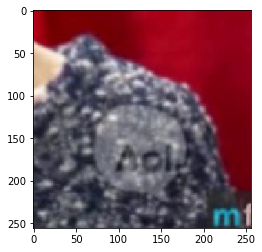

In [18]:
# teste
# Rendering image X with label y for MesoNet
X, y = generator.next()

# Evaluating prediction
print(f"Predicted likelihood: {meso_misto.predict(X)[0][0]:.4f}")
print(f"Actual label: {int(y[0])}")
print(f"\nCorrect prediction: {round(meso_misto.predict(X)[0][0])==y[0]}")

# Showing image
plt.imshow(np.squeeze(X))